In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
from scipy.interpolate import make_interp_spline
from dotenv import load_dotenv
from sklearn.preprocessing import MinMaxScaler

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings("ignore", message="Workbook contains no default style, apply openpyxl's default")

# 환경 변수 로드
load_dotenv()
file_path_subway = os.getenv('FiLE_PATH_subway')
file_path_timeday = os.getenv('FiLE_PATH_timeday')
file_path_timeweek = os.getenv("FiLE_PATH_timeweek")
file_image_traffic = os.getenv('File_image_traffic')

# CSV 파일 읽기
df_subway = pd.read_csv(file_path_subway, encoding='euc-kr')
df_timeday = pd.read_csv(file_path_timeday, encoding='euc-kr')
df_timeweek = pd.read_csv(file_path_timeweek, encoding='euc-kr')




In [2]:
# === [1] 지하철 시간대별 합계 계산 ===
time_list = df_subway.columns[4:]
one = [col for col in time_list if "00시-01시" in col or "01시-02시" in col or "02시-03시" in col]
two = [col for col in time_list if "03시-04시" in col or "04시-05시" in col or "05시-06시" in col]
three = [col for col in time_list if "06시-07시" in col or "07시-08시" in col or "08시-09시" in col]
four = [col for col in time_list if "09시-10시" in col or "10시-11시" in col or "11시-12시" in col]
five = [col for col in time_list if "12시-13시" in col or "13시-14시" in col or "14시-15시" in col]
six = [col for col in time_list if "15시-16시" in col or "16시-17시" in col or "17시-18시" in col]
seven = [col for col in time_list if "18시-19시" in col or "19시-20시" in col or "20시-21시" in col]
eight = [col for col in time_list if "21시-22시" in col or "22시-23시" in col or "23시-24시" in col]


In [3]:

# 지하철 시간대별 합계
subway_sums = [
    sum(df_subway[one].sum(axis=1)),
    sum(df_subway[two].sum(axis=1)),
    sum(df_subway[three].sum(axis=1)),
    sum(df_subway[four].sum(axis=1)),
    sum(df_subway[five].sum(axis=1)),
    sum(df_subway[six].sum(axis=1)),
    sum(df_subway[seven].sum(axis=1)),
    sum(df_subway[eight].sum(axis=1)),
]


In [4]:
# === [2] 차량량 시간대별 합계 계산 ===
years = [2020, 2021, 2022, 2023]

# year 컬럼 정리
df_timeday['year'] = pd.to_numeric(df_timeday['year'], errors='coerce').astype('Int64')
df_timeweek['year'] = pd.to_numeric(df_timeweek['year'], errors='coerce').astype('Int64')

timeday_chunked_dict = {}
timeweek_chunked_dict = {}

for year in years:
    df_day = df_timeday[df_timeday["year"] == year].drop('year', axis=1)
    df_day = df_day.apply(pd.to_numeric, errors='coerce').fillna(0)
    row_sums_day = df_day.sum(axis=1)
    sliced_day = row_sums_day[1:25]
    chunked_day = [sliced_day[i:i + 3] for i in range(0, len(sliced_day), 3)]
    timeday_chunked_dict[year] = chunked_day

    df_week = df_timeweek[df_timeweek["year"] == year].drop('year', axis=1)
    df_week = df_week.apply(pd.to_numeric, errors='coerce').fillna(0)
    row_sums_week = df_week.sum(axis=1)
    sliced_week = row_sums_week[1:25]
    chunked_week = [sliced_week[i:i + 3] for i in range(0, len(sliced_week), 3)]
    timeweek_chunked_dict[year] = chunked_week



In [5]:
# 차량량 시간대별 합계 (2020~2023 모든 연도 합산)
car_sums = []
for chunk_idx in range(8):
    total = 0
    for year in years:
        total += sum(timeweek_chunked_dict[year][chunk_idx])
        total += sum(timeday_chunked_dict[year][chunk_idx])
    car_sums.append(total)



In [6]:
# === [3] 버스 시간대별 합계 계산 ===
file_path_bus = os.getenv('FiLE_PATH_bus')

# 연도별 파일 리스트 딕셔너리 초기화
file_lists = {year: [] for year in ['2022', '2023', '2024', '2025']}
file_path_2021 = None  # 그 외 파일 (2021)


In [7]:
# 폴더 내 모든 파일 확인

for root, dirs, files in os.walk(file_path_bus):
    for file in files:
        full_path = os.path.join(root, file)
        added = False
        for year in file_lists:
            if year in full_path:
                file_lists[year].append(full_path)
                added = True
                break
        if not added:
            file_path_2021 = full_path


In [8]:
# 연도별 파일 데이터 저장용 딕셔너리
file_data = {year: {} for year in ['2022', '2023', '2024', '2025']}

# 파일 읽기
for year in ['2022', '2023', '2024']:
    for idx, path in enumerate(file_lists[year]):
        file_data[year][idx] = pd.read_csv(path, encoding='euc-kr', low_memory=False)

# 2025는 따로 처리
for idx, path in enumerate(file_lists['2025']):
    file_data['2025'][idx] = pd.read_csv(path, encoding='euc-kr', low_memory=False)


In [9]:
# 병합된 데이터프레임 생성
df_combined = {}
df_combined['2021'] = pd.read_csv(file_path_2021, encoding='euc-kr', low_memory=False)
df_combined['2022'] = pd.concat(file_data['2022'].values(), ignore_index=True)
df_combined['2023'] = pd.concat(file_data['2023'].values(), ignore_index=True)
df_combined['2024'] = pd.concat(file_data['2024'].values(), ignore_index=True)
df_combined['2025'] = pd.concat(file_data['2025'].values(), ignore_index=True)

df_all_years = pd.concat(df_combined.values(), ignore_index=True)

# 데이터프레임 시간별 목록
time_list2 = df_all_years.columns[6:54]


In [10]:

# 시간대별 열 그룹화
one = [col for col in time_list2 if "1시" in col or "2시" in col or "3시" in col]
two = [col for col in time_list2 if "4시" in col or "5시" in col or "6시" in col]
three = [col for col in time_list2 if "7시" in col or "8시" in col or "9시" in col]
four = [col for col in time_list2 if "10시" in col or "11시" in col or "12시" in col]
five = [col for col in time_list2 if "13시" in col or "14시" in col or "15시" in col]
six = [col for col in time_list2 if "16시" in col or "17시" in col or "18시" in col]
seven = [col for col in time_list2 if "19시" in col or "20시" in col or "21시" in col]
eight = [col for col in time_list2 if "22시" in col or "23시" in col or "00시" in col]

In [11]:
# 시간대별 합계 계산
bus_sums = [
    sum(df_all_years[one].sum(axis=1)),    # 00-03시
    sum(df_all_years[two].sum(axis=1)),    # 03-06시
    sum(df_all_years[three].sum(axis=1)),  # 06-09시
    sum(df_all_years[four].sum(axis=1)),   # 09-12시
    sum(df_all_years[five].sum(axis=1)),   # 12-15시
    sum(df_all_years[six].sum(axis=1)),    # 15-18시
    sum(df_all_years[seven].sum(axis=1)),  # 18-21시
    sum(df_all_years[eight].sum(axis=1)),  # 21-24시
]



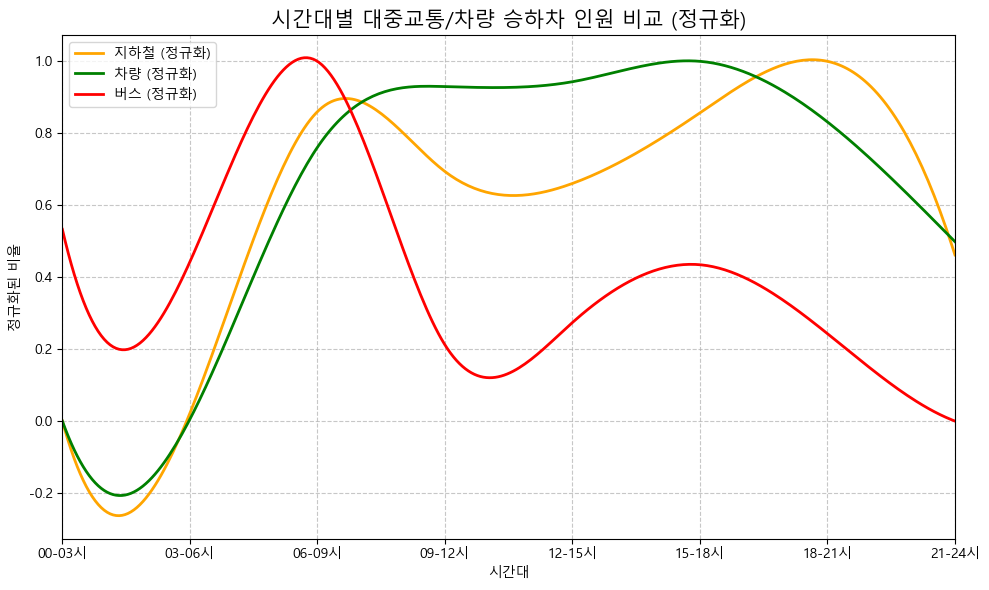

In [12]:
# === [3] 시각화 ===
time_labels = [
    "00-03시", "03-06시", "06-09시", "09-12시",
    "12-15시", "15-18시", "18-21시", "21-24시"
]

x_raw = np.linspace(0, 24, 8)
x_smooth = np.linspace(min(x_raw), max(x_raw), 300)


scaler = MinMaxScaler()
subway_norm = scaler.fit_transform(np.array(subway_sums).reshape(-1, 1)).flatten()
car_norm = scaler.fit_transform(np.array(car_sums).reshape(-1, 1)).flatten()
bus_norm = scaler.fit_transform(np.array(bus_sums).reshape(-1, 1)).flatten()

# 스플라인 보간
subway_norm_smooth = make_interp_spline(x_raw, subway_norm)(x_smooth)
car_norm_smooth = make_interp_spline(x_raw, car_norm)(x_smooth)
bus_norm_smooth = make_interp_spline(x_raw, bus_norm)(x_smooth)

plt.figure(figsize=(10, 6))
plt.plot(x_smooth, subway_norm_smooth, label='지하철 (정규화)', color='orange', linewidth=2)
plt.plot(x_smooth, car_norm_smooth, label='차량 (정규화)', color='green', linewidth=2)
plt.plot(x_smooth, bus_norm_smooth, label='버스 (정규화)', color='red', linewidth=2)

plt.xticks(x_raw, time_labels)
plt.xlim(0, 24)
plt.title("시간대별 대중교통/차량 승하차 인원 비교 (정규화)", fontsize=15)
plt.xlabel("시간대")
plt.ylabel("정규화된 비율")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
# 차트를 이미지로 저장 (PNG 형식)
plt.savefig(file_image_traffic, format="png", dpi=300)

##힙의 차이가 너무 지하철이 커서 car 이 일자형으로 나옴옴